# Mounting & Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bbox-visualizer
import bbox_visualizer as bbv
import numpy as np
import pandas as pd
import os
from glob import glob # Retrieve files/pathnames matching a specified pattern
import shutil, os #operations on files, operating system dependent functionality

import matplotlib.pyplot as plt
import seaborn as sns
#import bbox_visualizer as bbv

from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm #Progress bar

import cv2
from skimage.io import imread
from sklearn.model_selection import train_test_split


In [ ]:
#we are working with the trainning dataset as if it was it all (test results are not available as a kaggle competition is being held)
ds = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/train.csv')
ds.head(25)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0,2304,2880
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0,2540,3072


In [ ]:
ds.class_name.value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

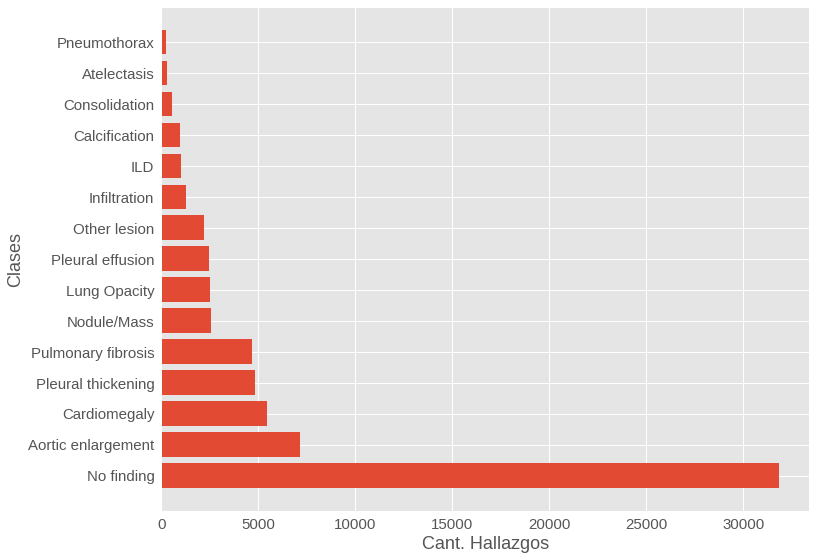

In [ ]:
fig = plt.figure(figsize=(9, 7))
plt.style.use('ggplot')
ax = fig.add_axes([0,0,1,1])
classes = ds.class_name.value_counts().index.to_numpy()
counts = ds.class_name.value_counts().to_numpy()
ax.barh(classes,counts)
ax.set_xlabel('Cant. Hallazgos', fontsize = 18)
ax.set_ylabel('Clases', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Generating Data Set 


In [ ]:
# Turning all classes into consolidation (see medical criteria applied)
ds2 =ds.replace({ 'class_name': 'Nodule/Mass'}, 'Consolidation')
ds2 =ds2.replace({ 'class_name': 'Atelectasis'}, 'Consolidation')
ds2 =ds2.replace({ 'class_name': 'Lung Opacity'}, 'Consolidation')
ds2.head(25)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
7,47ed17dcb2cbeec15182ed335a8b5a9e,Consolidation,8,R9,557.0,2352.0,675.0,2484.0,2568,3353
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0,2304,2880
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0,2540,3072


In [ ]:
cons = ds2[ds2["class_name"]=='Consolidation']
nimages = cons['image_id'].nunique()
print(nimages)
#Following the model recommendation (https://github.com/ultralytics/yolov5/wiki/Tips-for-Best-Training-Results), we add No Finding class images
nof = ds2[ds2["class_name"]=='No finding'].sample(n = round(nimages*0.05)) # 5% of the total amount of images
fds = pd.concat([cons,nof]).sample(frac=1)  
fds.class_name.value_counts()

1851


Consolidation    5898
No finding         93
Name: class_name, dtype: int64

In [ ]:
fds.to_excel('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/My_DS.xlsx')

# Exploring Images and Annotations

In [ ]:
fds = pd.read_excel('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/My_DS.xlsx')

In [ ]:
print("Number of unique images in the Data-frame: {}".format(fds['image_id'].nunique()))

Number of unique images in the Data-frame: 1944


In [ ]:
# Ask for help with this
%matplotlib inline
os.chdir('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/MyCode')
%run 'plot_img_bb.py' [fds,0,'/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/']

In [ ]:
def visualize_plot(idx):
    image = fds['image_id'].values[idx]
    records = fds[fds['image_id'] == image]
    boxes = np.array(records[['x_min','y_min','x_max','y_max']])
    
    labels = records.class_name
    sample = imread(os.path.join('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/','train',f'{image}.jpg'))
    img = cv2.cvtColor(sample,cv2.COLOR_GRAY2RGB)
    plt.figure(figsize=(12, 12))
    for box,label in zip(boxes,labels):
        bbv.add_label(img, 
                      label, 
                      [int(round(box[0])), int(round(box[1])),int(round(box[2])), int(round(box[3]))], 
                      draw_bg=True,
                      text_bg_color=(255,0,0),
                      text_color=(0,0,0),
                        )
        cv2.rectangle(img ,
                      (int(round(box[0])), int(round(box[1]))),
                      (int(round(box[2])), int(round(box[3]))),
                      (255,0,0),
                      2)

    plt.imshow(img)
    print('BB anotation looks like:{}'.format(boxes))

BB anotation looks like:[[1148.  911. 1693. 1482.]
 [1384. 1133. 1732. 1481.]
 [1357.  839. 1732. 1453.]
 [ 189. 1007.  710. 2035.]]


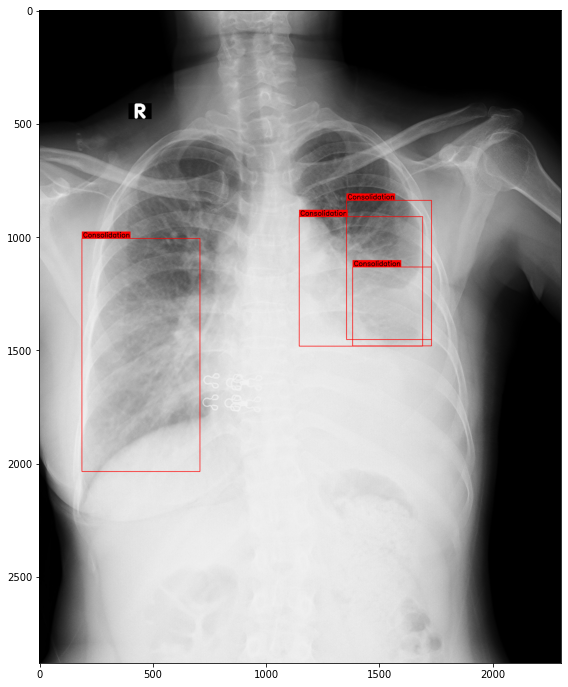

In [ ]:
#Notice that annotations aren't normalized
visualize_plot(0)

In [ ]:
# Normalizing Annotations 

# BB Normalized Limits
fds['x_min'] = fds.apply(lambda row: (row.x_min)/row.width, axis =1)
fds['y_min'] = fds.apply(lambda row: (row.y_min)/row.height, axis =1)

fds['x_max'] = fds.apply(lambda row: (row.x_max)/row.width, axis =1)
fds['y_max'] = fds.apply(lambda row: (row.y_max)/row.height, axis =1)

# BB Normalized Center
fds['x_mid'] = fds.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
fds['y_mid'] = fds.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

# BB Nomalized With & Height
fds['w'] = fds.apply(lambda row: (row.x_max-row.x_min), axis =1)
fds['h'] = fds.apply(lambda row: (row.y_max-row.y_min), axis =1)

# BB as a % area of the image
fds['area'] = fds['w']*fds['h']
fds.head()

,Unnamed: 0,Unnamed: 0.1,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,Group,x_mid,y_mid,w,h,area
0,0,57877,7b30d37b73be405bfd91ed5e2d46c473,Consolidation,7,R8,0.498264,0.316319,0.734809,0.514583,2304,2880,Train,0.616536,0.415451,0.236545,0.198264,0.046898
1,1,4860,7acb16c6d6f5cfc41a958e0b41e25106,Consolidation,7,R10,0.330295,0.334722,0.423611,0.491319,2304,2880,Train,0.376953,0.413021,0.093316,0.156597,0.014613
2,2,25382,6c79f2551808438721052023e043ab4d,Consolidation,4,R8,0.261393,0.376302,0.437826,0.486979,3072,3072,Train,0.349609,0.431641,0.176432,0.110677,0.019527
3,3,61581,ecf474d5d4f65d7a3e23370a68b8c6a0,Consolidation,8,R8,0.280316,0.230312,0.314369,0.262259,2408,2692,Train,0.297342,0.246285,0.034053,0.031947,0.001088
4,4,12091,4b001bab36d94f73c1ead3ab74690dbc,Consolidation,8,R9,0.813017,0.370981,0.824897,0.382235,1936,2488,Train,0.818957,0.376608,0.011880,0.011254,0.000134


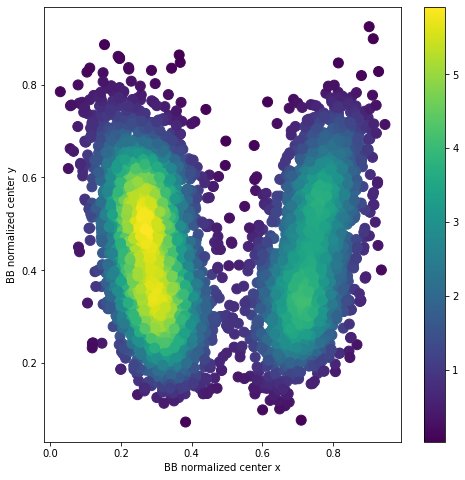

In [ ]:
# Localization of centres of BBs 
from scipy.stats import gaussian_kde

x = cons.x_mid.values
y = cons.y_mid.values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (8, 8))
sc = ax.scatter(x, y, c=z, s=100, cmap='viridis')
ax.set_xlabel('BB normalized center x')
ax.set_ylabel('BB normalized center y')
plt.colorbar(sc)
plt.show()

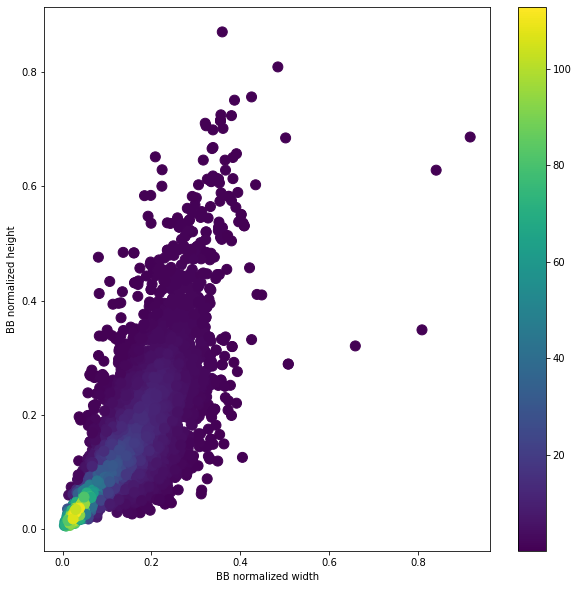

In [ ]:
x = cons.w.values
y = cons.h.values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
sc = ax.scatter(x, y, c=z, s=100, cmap='viridis')
ax.set_xlabel('BB normalized width')
ax.set_ylabel('BB normalized height')
plt.colorbar(sc)
plt.show()

# Split Train - Validation - Test

Things taken into account: number of images of each class and number of BB in Consolidation Class 

## Separating Consolidation images in two groups
 

In [ ]:
cons = fds[fds['class_name']=='Consolidation']
print("Max number of BB in a single Consolidation image: {}".format(cons.groupby(['image_id'])['class_name'].count().max()))
print("Min number of BB in a single Consolidation image: {}".format(cons.groupby(['image_id'])['class_name'].count().min()))

Max number of BB in a single Consolidation image: 55
Min number of BB in a single Consolidation image: 1


### Assesing Distribution in order to choose threshold

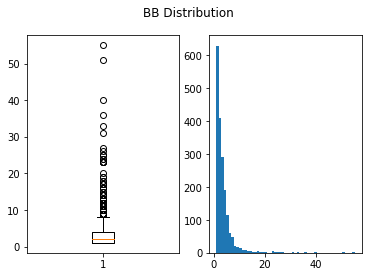

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('BB Distribution')
ax1.boxplot(cons.groupby(['image_id'])['image_id'].count())
ax2.hist(cons.groupby(['image_id'])['image_id'].count(),bins=55)
fig.show()


Most of the images have a small amount of BB (1 or 2). As the number of BB increases there are less and less images that fall into the group, but there are many outliers (greater value that 1.5 times the median)

In [ ]:
cons.groupby(['image_id'])['class_name'].count().describe()


count    1851.000000
mean        3.186386
std         3.769343
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        55.000000
Name: class_name, dtype: float64

In conclusion,it isn't a normal distribution, we must use median as a threshold instead of mean.

### Threshold cut
Based on the number of BB, we create the "Upper" and "Lower" groups. The upper one has more than 2 BB per image and the rest belong to the lower group. Then we perform a train validation split with stratification in these two groups. 

In [ ]:
csplit = pd.DataFrame({'BB Counts': cons.groupby(['image_id'])['image_id'].count()})
csplit

,BB Counts
image_id,
0005e8e3701dfb1dd93d53e2ff537b6e,4
000d68e42b71d3eac10ccc077aba07c1,2
00150343289f317a0ad5629d5b7d9ef9,2
0061cf6d35e253b6e7f03940592cc35e,1
008b3176a7248a0a189b5731ac8d2e95,9
...,...
ff0191df898268978f2c29231450fd66,3
ff335f1c7745c6184a5732cc5a01092d,2
ff4cd09578f32d803e5996a4a2ec29b2,1


In [ ]:
csplit['Upper'] = csplit['BB Counts'].gt(2)
csplit.groupby(['Upper']).count()

,BB Counts
Upper,
False,1038
True,813


### Train - Validation - Test Split
70% Train - 15% Validation - 15% Test

In [ ]:
(imgs_train_valid, imgs_test,class_train_valid, class_test) = train_test_split(csplit.index,
                                                                               csplit['Upper'].to_numpy(),
                                                                               test_size = 0.15, 
                                                                               random_state=42,
                                                                               stratify=csplit['Upper'].to_numpy())
(imgs_train, imgs_valid, class_train, class_valid) = train_test_split(imgs_train_valid,
                                                                      class_train_valid,
                                                                      test_size = 0.1767, 
                                                                      random_state=42, 
                                                                      stratify=class_train_valid)

In [ ]:
imgs_train

Index(['a8dd1496dde8d6f63316c8ec2a823b38', '4eed7a6bb03888eade13343f141dd5c8',
       'a0a6050fdda9f59eff1ca6a197883fcb', 'c42b5e8105ed48a96bf7273e25f2a047',
       'd700828f067b24ac9bc70bc8bbee1bea', 'b27c879787934c51d42095098dd313b2',
       '231a4b73de5ac7e0218f736b6b6ff1f2', 'f29df9890df1e30033396c8f220a9f14',
       '9b9f47628be6a48ddb41aec8ba39b454', 'c58bc096aa929d9645f0a15a62771893',
       ...
       '21d0e0bb639ebec0b2a2ce0c5c805344', 'b4ed7fedb5fd04e7a72bf8bc2f8aa91c',
       '5d2a481a562112395f28010b079a9cf1', 'f6fc6f200924da874ae95664661e67aa',
       '6072a9325dcf5318517a0696040a9dcc', 'ee9e445e316c60e028de2486e3f459df',
       '43e96bafa84091eec856901f949efa05', '0453de2faeb8d349af739a68d9dee1cb',
       '1c1ef26e3b3323f74041f6dd2371cd24', 'ee47fd39217a0d25550cb6b9badd3ee2'],
      dtype='object', name='image_id', length=1295)

### Saving 

In [ ]:
df_imgs_valid = pd.DataFrame(imgs_valid)
df_imgs_valid.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/cvalid.csv')
df_imgs_train = pd.DataFrame(imgs_train)
df_imgs_train.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/ctrain.csv')
df_imgs_test = pd.DataFrame(imgs_test)
df_imgs_test.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/ctest.csv')

In [ ]:
imgs_valid = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/cvalid.csv')
imgs_train = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/ctrain.csv')
imgs_test = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/ctest.csv')

## Separating images in two groups according to its class

In [ ]:
nof = fds[fds['class_name']=='No finding']
len(nof)

93

In [ ]:
nof

,Unnamed: 0,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
44,50590,19a8657db54ba2c4b22dc25bb33cc113,No finding,14,R16,NaN,NaN,NaN,NaN,3000,3000
103,10933,910e6bb0acb1c0b9156b4b7ae0dc752c,No finding,14,R16,NaN,NaN,NaN,NaN,2520,3032
186,24363,91783a3a0b479febd50ea952f711d776,No finding,14,R3,NaN,NaN,NaN,NaN,1994,2430
193,57501,50742e2516c5af7abede56edbd3bb6bb,No finding,14,R4,NaN,NaN,NaN,NaN,2174,2448
214,4851,bee99c179da019550328e64a55713d5e,No finding,14,R2,NaN,NaN,NaN,NaN,2048,2500
...,...,...,...,...,...,...,...,...,...,...,...
5760,2740,0abc9663ba5cfb779dbc26960dbc5b81,No finding,14,R5,NaN,NaN,NaN,NaN,1994,2430
5900,40243,162b6f2f6f04c9ab806583092dfadc13,No finding,14,R7,NaN,NaN,NaN,NaN,2715,2871
5972,13175,59f163522f9e49ab143f88d3febb8a33,No finding,14,R12,NaN,NaN,NaN,NaN,2279,2401
5980,42102,f0591ae18efc36ec22302f52a8ad7667,No finding,14,R3,NaN,NaN,NaN,NaN,1994,2430


In [ ]:
(train_valid, test) = train_test_split(nof['image_id'],test_size = 0.15, random_state=42)
(train, valid) = train_test_split(train_valid,test_size = 0.1767,random_state=42)

In [ ]:
type(test)

pandas.core.series.Series

In [ ]:
valid.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nfvalid.csv')
train.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nftrain.csv')
test.to_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nftest.csv')

In [ ]:
valid = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nfvalid.csv')
train = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nftrain.csv')
test = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nftest.csv')

## Final Split
Guided by both previous sections 

In [ ]:
trains = np.concatenate((imgs_train,train))
valids = np.concatenate((imgs_valid,valid))
tests = np.concatenate((imgs_test,test))

In [ ]:
print(np.shape(imgs_train))
print(np.shape(train))
trains = np.concatenate((imgs_train,train))
print(np.shape(trains))

(1295,)
(65,)
(1360,)


In [ ]:
fds['Group'] = ''

In [ ]:
# Código ineficiente, tarda mucho en correr. 
for i in trains:
  for index, row in fds.iterrows():
    if (i==row['image_id']):
      fds.loc[index, 'Group'] = 'Train'

In [ ]:
valids = np.concatenate((imgs_valid,valid))
for i in valids:
  for index, row in fds.iterrows():
    if (i==row['image_id']):
      fds.loc[index, 'Group'] = 'Valid'

In [ ]:
tests = np.concatenate((imgs_test,test))
for i in tests:
  for index, row in fds.iterrows():
    if (i==row['image_id']):
      fds.loc[index, 'Group'] = 'Test'

In [ ]:
fds.tail(40)

,Unnamed: 0,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,Group
5951,38832,4fa30afdf5d4bbfcfd9071e2a56e7a4b,Consolidation,1,R10,498.0,436.0,1057.0,1977.0,2304,2880,Train
5952,59936,693008c77b426c4afc45e990f5f07287,Consolidation,7,R9,1055.0,823.0,1406.0,1352.0,2048,2500,Train
5953,46598,02562eb68a9c682f5f644fa7a099733f,Consolidation,8,R9,1610.0,919.0,1668.0,991.0,2304,2880,Test
5954,59789,53e93d9f8cf885a55e00079256595a86,Consolidation,8,R8,1838.0,1972.0,2143.0,2349.0,2708,3404,Train
5955,21325,4b8c24a1eaeabd898c28a92d25cc3632,Consolidation,7,R9,808.0,519.0,1025.0,1114.0,2304,2880,Train
5956,27296,624fadcfe3f204dd43ce49bdce00c0f4,Consolidation,8,R9,326.0,1146.0,389.0,1199.0,2152,2376,Valid
5957,57014,b6e15b40a6370f847f1cb97f73528068,Consolidation,7,R10,876.0,507.0,1165.0,1056.0,2540,3072,Train
5958,24976,d106ec9b305178f3da060efe3191499a,Consolidation,8,R8,2483.0,2202.0,2568.0,2272.0,2896,3264,Train
5959,15374,fc206ae1d3ef8a63e90642dba9f75e4a,Consolidation,7,R9,251.0,309.0,770.0,854.0,2024,2176,Train
5960,1357,018a2fe44c3451281ec338c27ecc9c53,Consolidation,7,R10,328.0,1027.0,1097.0,2195.0,2512,2944,Train


In [ ]:
# Asses results
fds.groupby(['Group'])['Group'].count()

Group
Test      863
Train    4228
Valid     900
Name: Group, dtype: int64

In [ ]:
fds.to_excel('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/fds_withsplit.xlsx')

In [ ]:
fds = pd.read_excel('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/fds_withsplit.xlsx')

In [ ]:
print(len(fds))
print(len(fds.drop_duplicates()))

5991
5991


# Organizing Images and Labels

In [ ]:
# Creating directories
os.makedirs('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/labels/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/labels/val', exist_ok = True)
os.makedirs('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/labels/test', exist_ok = True)
os.makedirs('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/images/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/images/val', exist_ok = True)
os.makedirs('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/images/test', exist_ok = True)

## Images

In [ ]:
train = train.image_id.to_numpy()
imgs_train = imgs_train.image_id.to_numpy()
valid = valid.image_id.to_numpy()
imgs_valid = imgs_valid.image_id.to_numpy()
test = test.image_id.to_numpy()
imgs_test = imgs_test.image_id.to_numpy()

In [ ]:
# Assigning images to their corresponding directories
for file in tqdm(trains):
  shutil.copy('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/train/'+file+'.jpg','/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/images/train')
  
for file in tqdm(imgs_valid):
  shutil.copy('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/train/'+file+'.jpg','/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/images/val')
  
for file in tqdm(imgs_test):
  shutil.copy('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/train/'+file+'.jpg','/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/images/test')
  

## Labels

In [ ]:
fds = pd.read_excel('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/fds_withsplit.xlsx')


In [ ]:
# Normalizing Annotations 

# BB Normalized Limits
fds['x_min'] = fds.apply(lambda row: (row.x_min)/row.width, axis =1)
fds['y_min'] = fds.apply(lambda row: (row.y_min)/row.height, axis =1)

fds['x_max'] = fds.apply(lambda row: (row.x_max)/row.width, axis =1)
fds['y_max'] = fds.apply(lambda row: (row.y_max)/row.height, axis =1)

# BB Normalized Center
fds['x_mid'] = fds.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
fds['y_mid'] = fds.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

# BB Nomalized With & Height
fds['w'] = fds.apply(lambda row: (row.x_max-row.x_min), axis =1)
fds['h'] = fds.apply(lambda row: (row.y_max-row.y_min), axis =1)

# BB as a % area of the image
fds['area'] = fds['w']*fds['h']
fds.head()

In [ ]:
fds

,Unnamed: 0,Unnamed: 0.1,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,Group,x_mid,y_mid,w,h,area
0,0,57877,7b30d37b73be405bfd91ed5e2d46c473,Consolidation,7,R8,0.498264,0.316319,0.734809,0.514583,2304,2880,Train,0.616536,0.415451,0.236545,0.198264,0.046898
1,1,4860,7acb16c6d6f5cfc41a958e0b41e25106,Consolidation,7,R10,0.330295,0.334722,0.423611,0.491319,2304,2880,Train,0.376953,0.413021,0.093316,0.156597,0.014613
2,2,25382,6c79f2551808438721052023e043ab4d,Consolidation,4,R8,0.261393,0.376302,0.437826,0.486979,3072,3072,Train,0.349609,0.431641,0.176432,0.110677,0.019527
3,3,61581,ecf474d5d4f65d7a3e23370a68b8c6a0,Consolidation,8,R8,0.280316,0.230312,0.314369,0.262259,2408,2692,Train,0.297342,0.246285,0.034053,0.031947,0.001088
4,4,12091,4b001bab36d94f73c1ead3ab74690dbc,Consolidation,8,R9,0.813017,0.370981,0.824897,0.382235,1936,2488,Train,0.818957,0.376608,0.011880,0.011254,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5986,5986,22141,8cb084ad48ad4a21e15bdb8f4567ed8f,Consolidation,8,R17,0.500406,0.185343,0.691403,0.451214,2466,2347,Train,0.595904,0.318279,0.190998,0.265871,0.050781
5987,5987,27395,ec6ec12533b8495bb7344d8895dd4f05,Consolidation,7,R10,0.690538,0.454514,0.783420,0.590625,2304,2880,Valid,0.736979,0.522569,0.092882,0.136111,0.012642
5988,5988,28828,5d6c0df203f0e3f04467e27507029026,Consolidation,1,R9,0.629604,0.221773,0.834795,0.487361,2851,2967,Valid,0.732199,0.354567,0.205191,0.265588,0.054496
5989,5989,25185,0b98b21145a9425bf3eeea4b0de425e7,Consolidation,4,R10,0.153986,0.400670,0.383152,0.576637,2208,2688,Train,0.268569,0.488653,0.229167,0.175967,0.040326


In [ ]:
imgs_valid = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/cvalid.csv')
imgs_train = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/ctrain.csv')
imgs_test = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/ctest.csv')

In [ ]:
valid = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nfvalid.csv')
train = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nftrain.csv')
test = pd.read_csv('/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/vinbigdata/nftest.csv')

In [ ]:
trains = np.concatenate((imgs_train,train))
valids = np.concatenate((imgs_valid,valid))
tests = np.concatenate((imgs_test,test))

In [ ]:
trains

array([[0, 'a8dd1496dde8d6f63316c8ec2a823b38'],
       [1, '4eed7a6bb03888eade13343f141dd5c8'],
       [2, 'a0a6050fdda9f59eff1ca6a197883fcb'],
       ...,
       [4849, '3e40696236bdb6dec60938d7f7d8aa2b'],
       [1832, '5e26f541d9d73c26f205d2406ea54a1e'],
       [5980, 'f0591ae18efc36ec22302f52a8ad7667']], dtype=object)

In [ ]:
def create_labels(type):
  if(type=='val'):
    unique = valids
  elif (type =='train'):
    unique = trains
  elif(type=='test'):
    unique = tests
  label_dir =  '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/Part_II_DS/labels/' + str(type)
  for image in unique:
    my_list = []
    for index, row in fds.iterrows():
      if(image[1] == row['image_id']):
       if(row['class_name']=='Consolidation'): 
         my_list.append('0' + '\t' + str(row['x_mid']) + '\t' + str(row['y_mid']) + '\t' + str(row['w']) + '\t' + str(row['h']) + '\n')
    filename = image[1].split('.')[0]
    file1 = open(os.path.join(label_dir, filename+'.txt'),"w") 
    file1.writelines(np.unique(my_list))
    file1.close()


In [ ]:
create_labels('train')
#create_labels('valid')
#create_labels('test')

In [ ]:
create_labels('val')
create_labels('test')